<img src='logo_DH.png' align='center' width=35%/>

<h1 style="text-align: center;">Desafío 2 - Modelo de Regresión Lineal</h1>

<a id="section_toc"></a> 
## Tabla de Contenidos

[Introducción y objetivos](#section_intro)

[Importación de librerías y confguración de display()](#section_importacion)

[Importación del archivo properati_desafio_2](#section_properati)

[Inspección de la tabla](#section_inspeccion)

[Relaciones](#section_relaciones)

[Creación de variables dummies](#section_dummies)

[Modelo de regresión lineal](#section_modelo)

[Análisis de p-value (statsmodel)](#section_p)

[Mejora del modelo - Ridge, Lasso](#section_mejora)

---
<a id="section_intro"></a> 
## Introducción y objetivos

[volver a TOC](#section_toc)

La inmobiliaria Properati publica periódicamente información sobre ofertas de propiedades para venta y alquiler. Debemos asesorar a la inmobiliaria para desarrollar un modelo de regresión que permita predecir el **precio por metro cuadrado** de una propiedad. 

El objetivo final es que el modelo que desarrollen sea utilizado como **tasador automático** a ser aplicados a las próximas propiedades que sean comercializadas por la empresa. Para ello la empresa le provee de un dataset correspondiente al primer semestre de 2017. El nombre del dataset es *properati.csv*.

En el desafío 1 realizamos los primeros pasos de este objetivo:
- Efectuamos una limpieza del dataset provisto. Lidiamos con los datos perdidos en ciertas variables.
- Realizamos un análisis descriptivo de las principales variables.
- Creamos nuevas columnas a partir de las características dadas que puedan tener valor predictivo. En particular, se calcularon la amenities ya que no lo habíamos realizado.

En este desafío tenemos como objetivo realizar un modelo de regresión lineal que permite predecir el precio por metro cuadrado usando las variables que consideremos relevantes:
- Construcción de variables dummies para realizar el modelo si es necesario.
- Normalización.
- Train/test split del modelo.
- Cross validation.
- Regularización.
- Métricas RMSE y R² (ver para set de entrenamiento y de validación).

---
<a id="section_importacion"></a> 
## Importación de librerías y configuración de display()

[volver a TOC](#section_toc)


En esta parte importamos las librerías que usamos y cambiamos la configuración para tener un display/print correctos/útiles

In [92]:
# Importación de librerias:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import linear_model

import statsmodels.api as sm
import random

In [93]:
# Configuraciones de display:
pd.set_option("display.max_columns", 50)   # Limita la visualización a max 50 columnas. Si se excede genera "...".NO existe display.min_columns
pd.set_option("display.max_rows", 700)     # Limita la visualización a max 20 columnas. Si se excede genera "..."
pd.set_option("display.min_rows", 20)      # Una vez que display.max_rows se excede, la display.min_rows determina cuántas filas se muestran.
#pd.reset_option("^display")               # Este comando resetea todas las opciones por defecto.

---
<a id="section_properati"></a> 
## Importación del archivo properati_desafio_2.csv

[volver a TOC](#section_toc)

Del desafío 1 exportamos el siguiente dataset únicamente con las variables que considermao importantes que podrán ser relevante para el modelo:
    
property_type - tipo de propiedad

place_name - provincia

state_name - localidad

price_aprox_usd - precio usd

surface_total_in_m2 - superficie total

surface_covered_in_m2 - superficie cubierta

price_usd_per_m2 - precio por metro cuadrado (superficie total)

price_per_m2 - precio por metro cuadrado (superficie cubierta)

floor - piso

rooms - habitaciones

expenses - expensas

centro_urbano - provincias agrupadas en centros urbanos

pileta -  tiene pileta

parrilla - tiene parrila

quincho -  tiene quincho

patio - tiene patio

cochera - tiene cochera

balcon -  tiene cochera

amenities - cantidad de amenities (amenities en total que tiene)

In [94]:
# Importación del archivo de Properati:
data = pd.read_csv("properati_desafio_2.csv", sep = ",", low_memory=False) # low_memory=False es para que lea el archivo con la mayor cantidad de memoria dsponible y no infiera "mal" un tipo de dato.

In [95]:
# Muestra de la tabla:
data.sample(5)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities
22900,APARTMENT,MAR DEL PLATA,BUENOS AIRES COSTA ATLÁNTICA,45000.0,25.0,NaN,1800.000000,NaN,NaN,2.0,NaN,BUENOS AIRES COSTA ATLÁNTICA,0,0,0,0,0,0,0
32014,APARTMENT,SAN TELMO,CAPITAL FEDERAL,99900.0,34.0,28.0,2938.235294,3567.857143,NaN,1.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0
13486,APARTMENT,OLIVOS,BS.AS. G.B.A. ZONA NORTE,279552.0,92.0,75.0,3038.608696,3727.360000,9.0,NaN,NaN,BS.AS. G.B.A. ZONA NORTE,1,1,0,1,1,0,4
33308,APARTMENT,SAAVEDRA,CAPITAL FEDERAL,90195.0,39.0,33.0,2312.692308,2733.181818,NaN,NaN,1.0,CAPITAL FEDERAL,0,0,0,0,1,1,2
23244,APARTMENT,BALVANERA,CAPITAL FEDERAL,153000.0,56.0,49.0,2732.142857,3122.448980,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0


---
<a id="section_inspeccion"></a> 
## Inspección de la tabla

[volver a TOC](#section_toc)

Se realiza un análisis básico para recordar las variables.

In [5]:
# Dimensiones:
print("Dimensiones de la tabla: ", data.shape)

Dimensiones de la tabla:  (60678, 19)


In [96]:
# Tipo de datos de las columnas:
data.dtypes

property_type             object
place_name                object
state_name                object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
price_usd_per_m2         float64
price_per_m2             float64
floor                    float64
rooms                    float64
expenses                 float64
centro_urbano             object
pileta                     int64
parrilla                   int64
quincho                    int64
patio                      int64
cochera                    int64
balcon                     int64
amenities                  int64
dtype: object

Analizando las columnas una a una podemos ver que los tipos de datos son los correctos segun muestra el df.

In [97]:
# Para evitar inconvenientes en el análisis pasamos todos los strings a uppercase():
data = data.applymap(lambda x: x.upper() if type(x) == str else x)
display(data.sample(3))

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities
56471,APARTMENT,VILLA LIBERTAD,BS.AS. G.B.A. ZONA NORTE,80000.0,70.0,60.0,1142.857143,1333.333333,NaN,3.0,NaN,BS.AS. G.B.A. ZONA NORTE,0,0,0,0,0,1,1
3386,HOUSE,BARRIO SAN RAFAEL,BS.AS. G.B.A. ZONA NORTE,427000.0,267.0,234.0,1599.250936,1824.786325,NaN,NaN,NaN,BS.AS. G.B.A. ZONA NORTE,1,1,0,0,0,0,2
59111,PH,MAR DEL PLATA,BUENOS AIRES COSTA ATLÁNTICA,47000.0,46.0,40.0,1021.739130,1175.000000,NaN,2.0,NaN,BUENOS AIRES COSTA ATLÁNTICA,0,0,0,1,0,0,1


In [98]:
# Porcentaje de nulos por columnas:
(data.isnull().sum()/data.shape[0]*100).round(2)

property_type             0.00
place_name                0.03
state_name                0.00
price_aprox_usd           0.00
surface_total_in_m2       0.00
surface_covered_in_m2     7.82
price_usd_per_m2          0.00
price_per_m2              7.82
floor                    95.11
rooms                    54.77
expenses                 83.17
centro_urbano             0.00
pileta                    0.00
parrilla                  0.00
quincho                   0.00
patio                     0.00
cochera                   0.00
balcon                    0.00
amenities                 0.00
dtype: float64

---
<a id="section_relaciones"></a> 
## Relaciones

[volver a TOC](#section_toc)

Veamos mediante una matriz de correlaciones las posibles correlaciones entre las diferentes variables que pueden resultar útiles para el modelo:

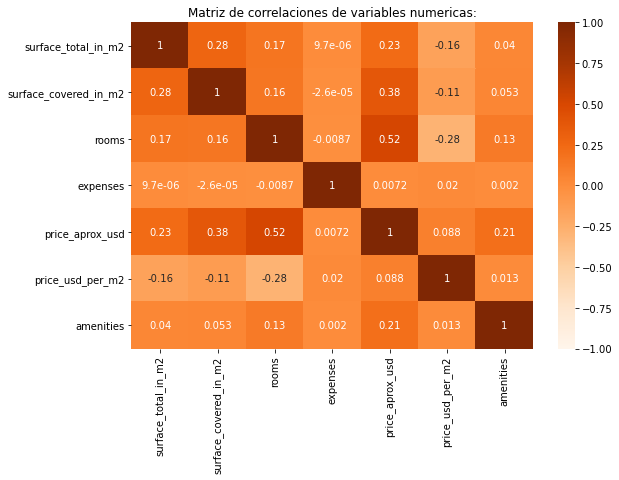

In [99]:
# Graficamos un heatmap con las variables numericas que pueden resultar útiles para el modelo:
data_numerico_mask = data[['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'expenses', 'price_aprox_usd', 'price_usd_per_m2', 'amenities']]

plt.figure(figsize=(9,6))
sns.heatmap(data_numerico_mask.corr(), annot=True, vmin=-1, cmap='Oranges').set_title('Matriz de correlaciones de variables numericas:');

#### Analizamos la relación de las variables contínuas mas relevantes
[volver a TOC](#section_toc)

(0.0, 7923.390014810531)

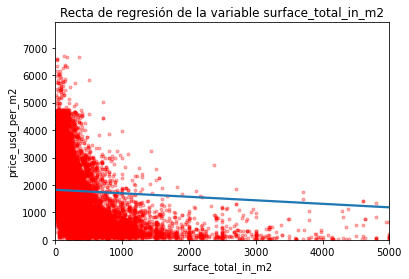

In [100]:
# Graficamos una recta de regresión de la variable surface_total_in_m2:
sns.regplot(data.surface_total_in_m2, data.price_usd_per_m2, order=1, ci=None, scatter_kws={'color':'r', 's':9,'alpha':.3}).set_title('Recta de regresión de la variable surface_total_in_m2')
plt.xlim(-10,5000)
plt.ylim(bottom=0)

(0.0, 7509.694278450957)

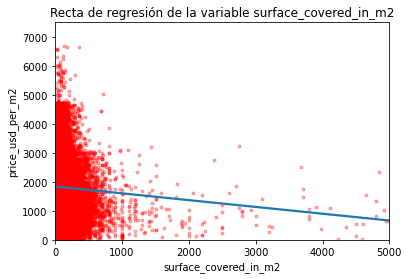

In [101]:
# Graficamos una recta de regresión de la variable surface_covered_in_m2:
sns.regplot(data.surface_covered_in_m2, data.price_usd_per_m2, order=1, ci=None, scatter_kws={'color':'r', 's':9, 'alpha':.3}).set_title('Recta de regresión de la variable surface_covered_in_m2')
plt.xlim(-10,5000)
plt.ylim(bottom=0)

(0.0, 6427.900145016259)

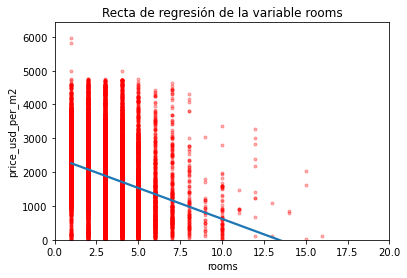

In [102]:
# Graficamos una recta de regresión de la variable rooms, pero luego la transformaremos en variable dummie:
sns.regplot(data.rooms, data.price_usd_per_m2, order=1, ci=None, scatter_kws={'color':'r', 's':9,'alpha':.3}).set_title('Recta de regresión de la variable rooms')
plt.xlim(0,20)
plt.ylim(bottom=0)

Podemos ver que las variables que "mas aportan" al modelo pueden ser, superficie y rooms

#### Analizamos la relación de las variables discretas/categóricas mas relevantes
[volver a TOC](#section_toc)

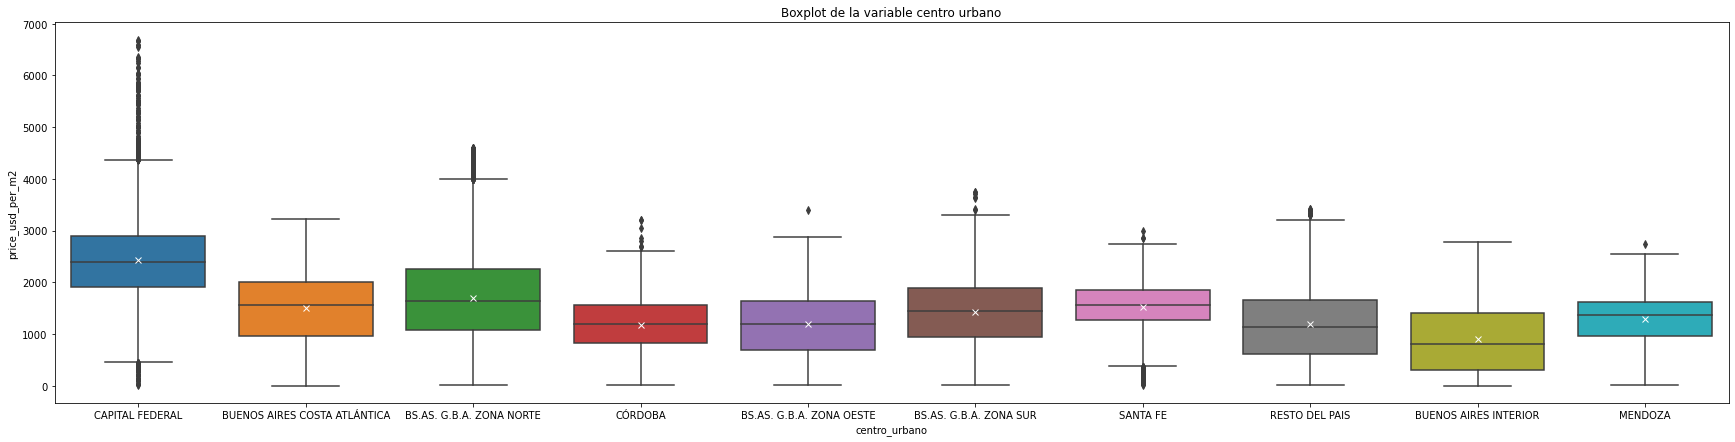

In [103]:
# Analizamos la distribución de las variables categoricas para verificar cuales podrían aportar mayor información al modelo:
plt.figure(figsize=(30,7))
sns.boxplot(x='centro_urbano', y='price_usd_per_m2', data=data, showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable centro urbano');

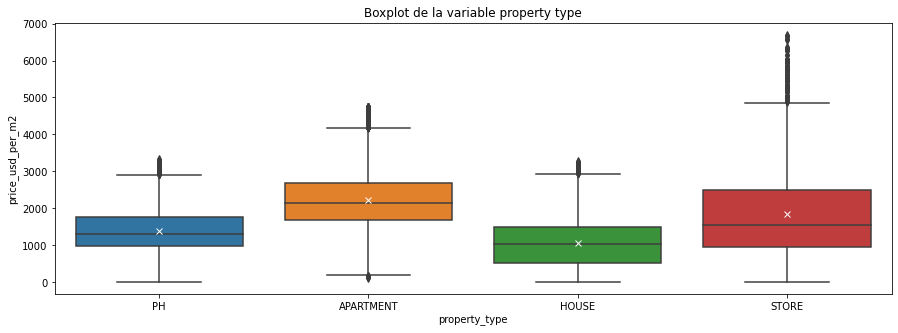

In [104]:
plt.figure(figsize=(15,5))
sns.boxplot(x='property_type', y='price_usd_per_m2', data=data, showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable property type');

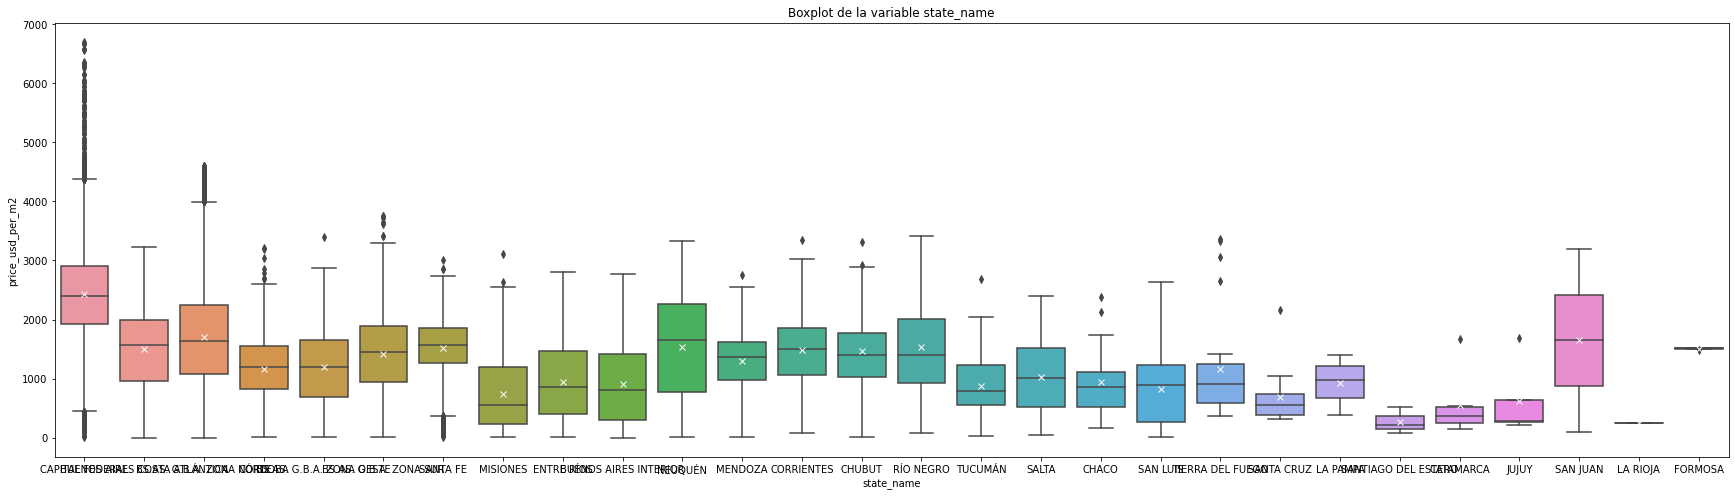

In [105]:
plt.figure(figsize=(30,8))
sns.boxplot(x='state_name', y='price_usd_per_m2', data=data, showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable state_name');

Podemos ver que existe una gran dispersión de las medías por lo que cuanto mayor es la diferencia en el promedio entre las variables, mas va a aportar al modelo

Gráficos de algunas otras variables categóricas:

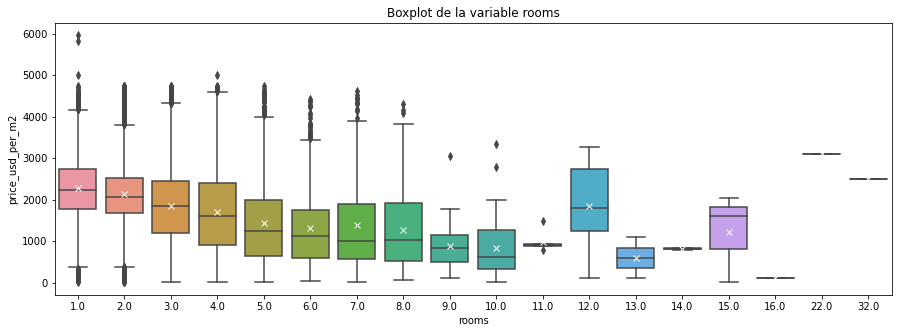

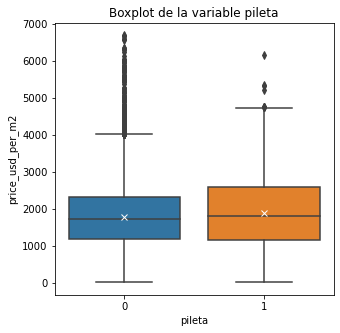

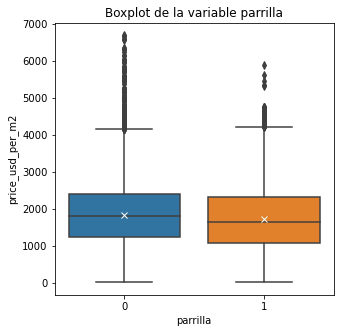

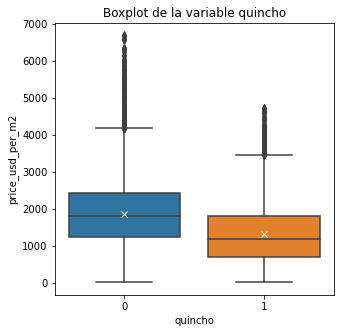

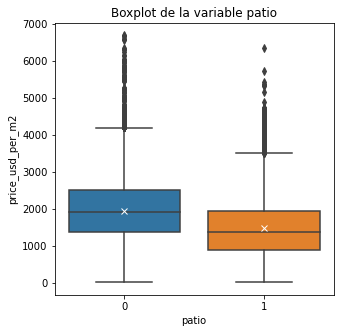

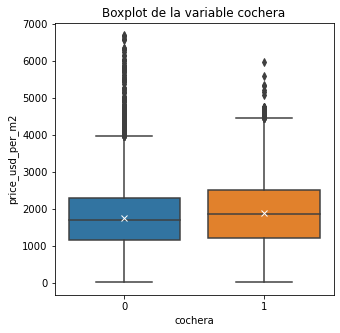

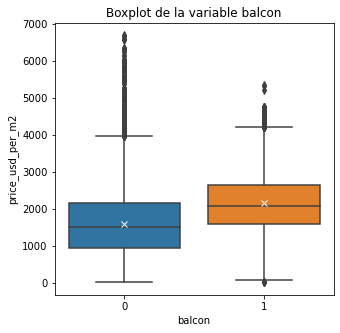

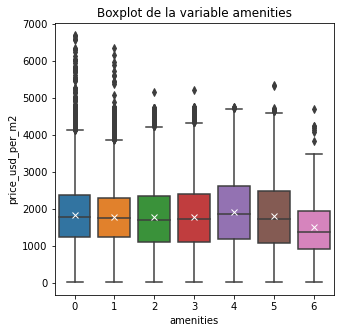

In [106]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'rooms', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable rooms');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'pileta', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable pileta');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'parrilla', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable parrilla');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'quincho', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable quincho');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'patio', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable patio');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'cochera', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable cochera');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'balcon', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable balcon');
plt.figure(figsize=(5,5))
sns.boxplot(x = 'amenities', y = 'price_usd_per_m2', data=data,
           showmeans=True, meanprops={'marker':'x','markeredgecolor':'w'}).set_title('Boxplot de la variable amenities');

---
<a id="section_dummies"></a> 
## Creación de variables Dummies

[volver a TOC](#section_toc)

In [107]:
#mTransformamos la variable centro_urbano en variable dummies:
centrourbano_dummies = pd.get_dummies(data.centro_urbano, drop_first = True, prefix='dummy')
data = pd.concat([data, centrourbano_dummies], axis=1, sort=False)
data.head(2)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities,dummy_BS.AS. G.B.A. ZONA OESTE,dummy_BS.AS. G.B.A. ZONA SUR,dummy_BUENOS AIRES COSTA ATLÁNTICA,dummy_BUENOS AIRES INTERIOR,dummy_CAPITAL FEDERAL,dummy_CÓRDOBA,dummy_MENDOZA,dummy_RESTO DEL PAIS,dummy_SANTA FE
0,PH,MATADEROS,CAPITAL FEDERAL,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,APARTMENT,MATADEROS,CAPITAL FEDERAL,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [108]:
# Transformamos la variable property_type en variable dummies:
property_type_dummies = pd.get_dummies(data.property_type, drop_first = True, prefix='dummy')
data = pd.concat([data, property_type_dummies], axis=1, sort=False)
data.head(2)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities,dummy_BS.AS. G.B.A. ZONA OESTE,dummy_BS.AS. G.B.A. ZONA SUR,dummy_BUENOS AIRES COSTA ATLÁNTICA,dummy_BUENOS AIRES INTERIOR,dummy_CAPITAL FEDERAL,dummy_CÓRDOBA,dummy_MENDOZA,dummy_RESTO DEL PAIS,dummy_SANTA FE,dummy_HOUSE,dummy_PH,dummy_STORE
0,PH,MATADEROS,CAPITAL FEDERAL,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,APARTMENT,MATADEROS,CAPITAL FEDERAL,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [109]:
# Transformamos la variable state_name en variable dummies:
state_name_dummies = pd.get_dummies(data.state_name, drop_first = True, prefix='state_dummy_')
data = pd.concat([data, state_name_dummies], axis=1, sort=False)
data.head(2)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities,dummy_BS.AS. G.B.A. ZONA OESTE,dummy_BS.AS. G.B.A. ZONA SUR,dummy_BUENOS AIRES COSTA ATLÁNTICA,dummy_BUENOS AIRES INTERIOR,dummy_CAPITAL FEDERAL,dummy_CÓRDOBA,...,state_dummy__BUENOS AIRES COSTA ATLÁNTICA,state_dummy__BUENOS AIRES INTERIOR,state_dummy__CAPITAL FEDERAL,state_dummy__CATAMARCA,state_dummy__CHACO,state_dummy__CHUBUT,state_dummy__CORRIENTES,state_dummy__CÓRDOBA,state_dummy__ENTRE RÍOS,state_dummy__FORMOSA,state_dummy__JUJUY,state_dummy__LA PAMPA,state_dummy__LA RIOJA,state_dummy__MENDOZA,state_dummy__MISIONES,state_dummy__NEUQUÉN,state_dummy__RÍO NEGRO,state_dummy__SALTA,state_dummy__SAN JUAN,state_dummy__SAN LUIS,state_dummy__SANTA CRUZ,state_dummy__SANTA FE,state_dummy__SANTIAGO DEL ESTERO,state_dummy__TIERRA DEL FUEGO,state_dummy__TUCUMÁN
0,PH,MATADEROS,CAPITAL FEDERAL,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,APARTMENT,MATADEROS,CAPITAL FEDERAL,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
# Transformamos la variable rooms en dummies:
rooms_dummies = pd.get_dummies(data.rooms, drop_first = True, prefix='rooms_dummy_')
data = pd.concat([data, rooms_dummies], axis=1, sort=False)
data.head(2)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities,dummy_BS.AS. G.B.A. ZONA OESTE,dummy_BS.AS. G.B.A. ZONA SUR,dummy_BUENOS AIRES COSTA ATLÁNTICA,dummy_BUENOS AIRES INTERIOR,dummy_CAPITAL FEDERAL,dummy_CÓRDOBA,...,state_dummy__SALTA,state_dummy__SAN JUAN,state_dummy__SAN LUIS,state_dummy__SANTA CRUZ,state_dummy__SANTA FE,state_dummy__SANTIAGO DEL ESTERO,state_dummy__TIERRA DEL FUEGO,state_dummy__TUCUMÁN,rooms_dummy__2.0,rooms_dummy__3.0,rooms_dummy__4.0,rooms_dummy__5.0,rooms_dummy__6.0,rooms_dummy__7.0,rooms_dummy__8.0,rooms_dummy__9.0,rooms_dummy__10.0,rooms_dummy__11.0,rooms_dummy__12.0,rooms_dummy__13.0,rooms_dummy__14.0,rooms_dummy__15.0,rooms_dummy__16.0,rooms_dummy__22.0,rooms_dummy__32.0
0,PH,MATADEROS,CAPITAL FEDERAL,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,APARTMENT,MATADEROS,CAPITAL FEDERAL,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# Transformamos la variable amenities en dummies:
amenities_dummies = pd.get_dummies(data.amenities, drop_first = True, prefix='amenities_dummy_')
data = pd.concat([data, amenities_dummies], axis=1, sort=False)
data.head(2)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,centro_urbano,pileta,parrilla,quincho,patio,cochera,balcon,amenities,dummy_BS.AS. G.B.A. ZONA OESTE,dummy_BS.AS. G.B.A. ZONA SUR,dummy_BUENOS AIRES COSTA ATLÁNTICA,dummy_BUENOS AIRES INTERIOR,dummy_CAPITAL FEDERAL,dummy_CÓRDOBA,...,state_dummy__TIERRA DEL FUEGO,state_dummy__TUCUMÁN,rooms_dummy__2.0,rooms_dummy__3.0,rooms_dummy__4.0,rooms_dummy__5.0,rooms_dummy__6.0,rooms_dummy__7.0,rooms_dummy__8.0,rooms_dummy__9.0,rooms_dummy__10.0,rooms_dummy__11.0,rooms_dummy__12.0,rooms_dummy__13.0,rooms_dummy__14.0,rooms_dummy__15.0,rooms_dummy__16.0,rooms_dummy__22.0,rooms_dummy__32.0,amenities_dummy__1,amenities_dummy__2,amenities_dummy__3,amenities_dummy__4,amenities_dummy__5,amenities_dummy__6
0,PH,MATADEROS,CAPITAL FEDERAL,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,APARTMENT,MATADEROS,CAPITAL FEDERAL,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,CAPITAL FEDERAL,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---
<a id="section_modelo"></a> 
## Modelo de regresión lineal

[volver a TOC](#section_toc)

Creamos una función que nos permite crear el modelo. Le pasamos como parámetro los features a considerar.

In [112]:
# Armamos una función para probar diferentes combinaciones de features:
def train_test(data, feature_cols, is_linear = 1, lm=None): #is_ilinear = 0 para regularización
    X = data[feature_cols]
    y = data.price_usd_per_m2

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
    lm = lm or LinearRegression()
    model = lm.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    mae = mean_absolute_error(y_pred_test, y_test)
    mse = mean_squared_error(y_pred_test, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_pred_test, y_test)
    
    print('La media del error absoluto es', mae.round(2))
    print('La raíz del error cuadrático medio', rmse.round(2))
    print('El R2 de entrenamiento del modelo es', r2_score(y_train, y_pred_train).round(6))
    print('El R2 de testeo del modelo es', r2_score(y_test, y_pred_test).round(6))
    
    if not is_linear:
        print("El alpha utilizado en la regularización es:", model.alpha_)
    
    return

#### Modelo lineal simple

[volver a TOC](#section_toc)

In [113]:
# Modelo con 1 variable numerica:
feature_cols1 = ['surface_total_in_m2']
train_test(data, feature_cols1, 1)

La media del error absoluto es 710.18
La raíz del error cuadrático medio 911.48
El R2 de entrenamiento del modelo es 0.031386
El R2 de testeo del modelo es 0.005439


Vemos que el modelo tiene muy bajo R2. No puede explicar a los datos.

#### Modelo lineal compuesto

[volver a TOC](#section_toc)

In [114]:
# Modelo con 1 variable numerica y dummies de centro urbano:
feature_cols2 = ['surface_total_in_m2', 'dummy_BS.AS. G.B.A. ZONA OESTE', 'dummy_BS.AS. G.B.A. ZONA SUR',
       'dummy_BUENOS AIRES COSTA ATLÁNTICA', 'dummy_BUENOS AIRES INTERIOR',
       'dummy_CAPITAL FEDERAL', 'dummy_CÓRDOBA', 'dummy_MENDOZA',
       'dummy_RESTO DEL PAIS', 'dummy_SANTA FE']

modelo_2 = train_test(data, feature_cols2)

La media del error absoluto es 597.46
La raíz del error cuadrático medio 775.32
El R2 de entrenamiento del modelo es 0.296582
El R2 de testeo del modelo es 0.280398


Agregando las variables dummies de centro_urbano aumenta el R2.

In [115]:
# Agregamos property_type:
feature_cols3 = ['surface_total_in_m2', 'dummy_BS.AS. G.B.A. ZONA OESTE', 'dummy_BS.AS. G.B.A. ZONA SUR',
       'dummy_BUENOS AIRES COSTA ATLÁNTICA', 'dummy_BUENOS AIRES INTERIOR',
       'dummy_CAPITAL FEDERAL', 'dummy_CÓRDOBA', 'dummy_MENDOZA',
       'dummy_RESTO DEL PAIS', 'dummy_SANTA FE', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE']

modelo_3 = train_test(data, feature_cols3)

La media del error absoluto es 505.63
La raíz del error cuadrático medio 655.95
El R2 de entrenamiento del modelo es 0.49386
El R2 de testeo del modelo es 0.484912


Vemos que con dummies de centro_urbano + dummies de tipo_propiedad, aumenta considerablemente el R2.

In [116]:
# Agregamos la variable state_name dummie:
feature_cols4 = ['surface_total_in_m2', 'dummy_BS.AS. G.B.A. ZONA OESTE', 'dummy_BS.AS. G.B.A. ZONA SUR',
       'dummy_BUENOS AIRES COSTA ATLÁNTICA', 'dummy_BUENOS AIRES INTERIOR',
       'dummy_CAPITAL FEDERAL', 'dummy_CÓRDOBA', 'dummy_MENDOZA',
       'dummy_RESTO DEL PAIS', 'dummy_SANTA FE', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN']
modelo_4 = train_test(data, feature_cols4)

La media del error absoluto es 503.26
La raíz del error cuadrático medio 653.61
El R2 de entrenamiento del modelo es 0.497502
El R2 de testeo del modelo es 0.488593


El modelo con todas las provincias + dummies centro_urbano + dummies tipo_propiedad explica muy levemente mejor que el modelo anterior. Estamos agregando variables que no suman al modelo.

In [117]:
# Analizamos el modelo con provincia en lugar de centro_urbano:
feature_cols5 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN']
modelo_5 = train_test(data, feature_cols5)

La media del error absoluto es 503.26
La raíz del error cuadrático medio 653.58
El R2 de entrenamiento del modelo es 0.497502
El R2 de testeo del modelo es 0.48863


Vemos que usando el centro urbano o provincias es similar (dado que una se construye de la otra).

In [118]:
# Agregamos al modelo la variable rooms:
feature_cols6 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0']
modelo_6 = train_test(data, feature_cols6)

La media del error absoluto es 500.96
La raíz del error cuadrático medio 652.63
El R2 de entrenamiento del modelo es 0.500161
El R2 de testeo del modelo es 0.490124


In [119]:
# Agregamos al modelo la variable pileta:
feature_cols7 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta']
modelo_7 = train_test(data, feature_cols7)

La media del error absoluto es 495.26
La raíz del error cuadrático medio 645.64
El R2 de entrenamiento del modelo es 0.514071
El R2 de testeo del modelo es 0.500981


In [120]:
# Agregamos al modelo la variable parrilla:
feature_cols8 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'parrilla']
modelo_8 = train_test(data, feature_cols8)

La media del error absoluto es 495.27
La raíz del error cuadrático medio 645.65
El R2 de entrenamiento del modelo es 0.514071
El R2 de testeo del modelo es 0.500972


In [121]:
# Agregamos al modelo la variable quincho:
feature_cols9 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho']
modelo_9 = train_test(data, feature_cols9)

La media del error absoluto es 494.96
La raíz del error cuadrático medio 645.29
El R2 de entrenamiento del modelo es 0.514348
El R2 de testeo del modelo es 0.50152


In [122]:
# Agregamos al modelo la variable patio:
feature_cols10 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio']

modelo_10 = train_test(data, feature_cols10)

La media del error absoluto es 494.81
La raíz del error cuadrático medio 645.13
El R2 de entrenamiento del modelo es 0.514832
El R2 de testeo del modelo es 0.501767


In [123]:
# Agregamos al modelo la variable cochera:
feature_cols11 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera']

modelo_11 = train_test(data, feature_cols11)

La media del error absoluto es 491.51
La raíz del error cuadrático medio 640.13
El R2 de entrenamiento del modelo es 0.522684
El R2 de testeo del modelo es 0.509468


In [124]:
# Agregamos al modelo la variable balcon:
feature_cols12 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon']

modelo_12 = train_test(data, feature_cols12)

La media del error absoluto es 490.63
La raíz del error cuadrático medio 638.97
El R2 de entrenamiento del modelo es 0.524305
El R2 de testeo del modelo es 0.511235


In [125]:
# Agregamos al modelo la variable amenities:
feature_cols13 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'amenities']

modelo_13 = train_test(data, feature_cols13)

La media del error absoluto es 490.8
La raíz del error cuadrático medio 638.99
El R2 de entrenamiento del modelo es 0.524414
El R2 de testeo del modelo es 0.511205


In [126]:
# Agregamos al modelo la variable amenities en formato dummies:
feature_cols14 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'amenities_dummy__1',
       'amenities_dummy__2', 'amenities_dummy__3', 'amenities_dummy__4',
       'amenities_dummy__5', 'amenities_dummy__6']

modelo_14 = train_test(data, feature_cols14)

La media del error absoluto es 494.76
La raíz del error cuadrático medio 645.23
El R2 de entrenamiento del modelo es 0.512596
El R2 de testeo del modelo es 0.501625


---
<a id="section_p"></a> 
## Análsis de p-value

[volver a TOC](#section_toc)

Analizaremos mediante statsmodel cuales son las variables que no aportan al modelo segun su p-value.

In [127]:
# Creamos una función que nos resuma el armado del modelo y los estadísticos:
def statsmodel_linear(data, features):
    X = data[features]
    y = data.price_usd_per_m2
    X = sm.add_constant(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_test)
    plt.plot(y_test,y_test, '-.', c='grey')
    plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicciones precio m2 en USD")
    plt.ylabel("Valores reales precio m2 en USD")
    plt.show()
    print (model.summary())
    print ('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print ('MSE:', metrics.mean_squared_error(y_test, predictions))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print ('R2:', metrics.r2_score(y_test,predictions))
    return

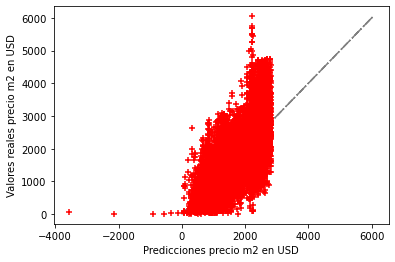

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     888.0
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:05:24   Log-Likelihood:            -3.5864e+05
No. Observations:               45508   AIC:                         7.174e+05
Df Residuals:                   45454   BIC:                         7.179e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [128]:
# Usamos todos los features para anlizar los p-value:
feature_cols = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'amenities_dummy__1',
       'amenities_dummy__2', 'amenities_dummy__3', 'amenities_dummy__4',
       'amenities_dummy__5', 'amenities_dummy__6']

stat_modelo_1 = statsmodel_linear(data, feature_cols)

---
<a id="section_mejora"></a> 
## Mejora del modelo - Ridge, Lasso

[volver a TOC](#section_toc)

Generamos nuevas variables para testear el modelo:

In [129]:
data['sup_2'] = data.surface_total_in_m2**2
data['sup_3'] = data.surface_total_in_m2**3
data['sup_4'] = data.surface_total_in_m2**4
data['sup_5'] = data.surface_total_in_m2**5
data['sup_log'] = np.log(data.surface_total_in_m2)

Usamos Ridge y Lasso para el testeo del modelo:

In [130]:
# Agregamos al modelo la variable surface_total_in_m2 en formato logaritmo:
feature_cols15 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log']

display(modelo_15 = train_test(data, feature_cols15))
print("-")
display(modelo_15_ = train_test(data, feature_cols15, 0, RidgeCV(normalize=True, cv=3)))

La media del error absoluto es 464.15
La raíz del error cuadrático medio 609.17
El R2 de entrenamiento del modelo es 0.564177
El R2 de testeo del modelo es 0.555767
-
La media del error absoluto es 466.35
La raíz del error cuadrático medio 611.22
El R2 de entrenamiento del modelo es 0.56067
El R2 de testeo del modelo es 0.552767
El alpha utilizado en la regularización es: 0.1


In [131]:
# Agregamos al modelo la variable surface_total_in_m2 en formato exponencial grado 2:
feature_cols16 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'sup_2']

modelo_16 = train_test(data, feature_cols16)

La media del error absoluto es 464.45
La raíz del error cuadrático medio 610.74
El R2 de entrenamiento del modelo es 0.564511
El R2 de testeo del modelo es 0.553481


In [132]:
# Agregamos al modelo la variable surface_total_in_m2 en formato exponencial grado 3:
feature_cols17 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'sup_2', 'sup_3']

modelo_17 = train_test(data, feature_cols17)

La media del error absoluto es 465.88
La raíz del error cuadrático medio 653.15
El R2 de entrenamiento del modelo es 0.565129
El R2 de testeo del modelo es 0.489308


In [133]:
#Le agregamos al modelo la variable surface_total_in_m2 en formato exponencial grado 4:
feature_cols18 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'sup_2', 'sup_3', 'sup_4']

modelo_18 = train_test(data, feature_cols18)

La media del error absoluto es 680.6
La raíz del error cuadrático medio 3139.31
El R2 de entrenamiento del modelo es 0.155891
El R2 de testeo del modelo es -10.797839


In [134]:
# Transformamos la variable surface_covered_in_m2 en logaritmo y transformamos sus valores infinitos en NaN:
data['sup_covered_log'] = np.log(data.surface_covered_in_m2)
data['sup_covered_log'] = data.sup_covered_log.replace([np.inf, -np.inf], np.nan)

C:\Users\maria\anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [135]:
#Eliminamos los valores nulos de la columna surface_covered_in_m2 para agregar esta variable al modelo:
sup_cubierta_sin_nulos = data.surface_covered_in_m2.notnull()
data_filtro = data.loc[sup_cubierta_sin_nulos]

In [136]:
#Eliminamos los valores nulos de la nueva variable sup_covered_log:
sup_cubierta_sin_nulos = data_filtro.sup_covered_log.notnull()
data_filtro = data_filtro.loc[sup_cubierta_sin_nulos]

In [137]:
#Le agregamos al modelo la variable surface_covered_in_m2 sin valores nulos:
feature_cols19 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'surface_covered_in_m2']

modelo_19 = train_test(data_filtro, feature_cols19)

La media del error absoluto es 456.3
La raíz del error cuadrático medio 600.85
El R2 de entrenamiento del modelo es 0.558714
El R2 de testeo del modelo es 0.572246


In [138]:
#Y la variable sup_covered_log:
feature_cols20 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'surface_covered_in_m2', 'sup_covered_log']

modelo_20 = train_test(data_filtro, feature_cols20)
print("-")
modelo_20_ = train_test(data_filtro, feature_cols20, 0, RidgeCV(normalize=True, cv=3))

La media del error absoluto es 434.17
La raíz del error cuadrático medio 579.7
El R2 de entrenamiento del modelo es 0.587915
El R2 de testeo del modelo es 0.601833
-
La media del error absoluto es 447.8
La raíz del error cuadrático medio 591.64
El R2 de entrenamiento del modelo es 0.572599
El R2 de testeo del modelo es 0.585255
El alpha utilizado en la regularización es: 0.1


In [171]:
#Testeamos nuevamente agregando la variable sup_2:
feature_cols21 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'surface_covered_in_m2', 'sup_covered_log', 'sup_2']
modelo_21 = train_test(data_filtro, feature_cols21)
print("-")
modelo_21_ = train_test(data_filtro, feature_cols21, 0, RidgeCV(normalize=True, cv=3))

La media del error absoluto es 433.76
La raíz del error cuadrático medio 579.41
El R2 de entrenamiento del modelo es 0.588428
El R2 de testeo del modelo es 0.602224
-
La media del error absoluto es 447.92
La raíz del error cuadrático medio 591.75
El R2 de entrenamiento del modelo es 0.572512
El R2 de testeo del modelo es 0.58511
El alpha utilizado en la regularización es: 0.1


In [158]:
#Testeamos nuevamente agregando la variable sup_3:
feature_cols22 = ['surface_total_in_m2', 'dummy_HOUSE', 'dummy_PH', 'dummy_STORE', 'state_dummy__BS.AS. G.B.A. ZONA OESTE',
       'state_dummy__BS.AS. G.B.A. ZONA SUR',
       'state_dummy__BUENOS AIRES COSTA ATLÁNTICA',
       'state_dummy__BUENOS AIRES INTERIOR', 'state_dummy__CAPITAL FEDERAL',
       'state_dummy__CATAMARCA', 'state_dummy__CHACO', 'state_dummy__CHUBUT',
       'state_dummy__CORRIENTES', 'state_dummy__CÓRDOBA',
       'state_dummy__ENTRE RÍOS', 'state_dummy__FORMOSA', 'state_dummy__JUJUY',
       'state_dummy__LA PAMPA', 'state_dummy__LA RIOJA',
       'state_dummy__MENDOZA', 'state_dummy__MISIONES', 'state_dummy__NEUQUÉN',
       'state_dummy__RÍO NEGRO', 'state_dummy__SALTA', 'state_dummy__SAN JUAN',
       'state_dummy__SAN LUIS', 'state_dummy__SANTA CRUZ',
       'state_dummy__SANTA FE', 'state_dummy__SANTIAGO DEL ESTERO',
       'state_dummy__TIERRA DEL FUEGO', 'state_dummy__TUCUMÁN', 'rooms_dummy__2.0', 'rooms_dummy__3.0', 'rooms_dummy__4.0',
       'rooms_dummy__5.0', 'rooms_dummy__6.0', 'rooms_dummy__7.0',
       'rooms_dummy__8.0', 'rooms_dummy__9.0', 'rooms_dummy__10.0',
       'rooms_dummy__11.0', 'rooms_dummy__12.0', 'rooms_dummy__13.0',
       'rooms_dummy__14.0', 'rooms_dummy__15.0', 'rooms_dummy__16.0',
       'rooms_dummy__22.0', 'rooms_dummy__32.0', 'pileta', 'quincho', 'patio', 'cochera', 'balcon', 'sup_log', 'surface_covered_in_m2', 'sup_covered_log', 'sup_2', 'sup_3']
modelo_22 = train_test(data_filtro, feature_cols22)
print("-")
modelo_22_ = train_test(data_filtro, feature_cols22, 0, RidgeCV(normalize=True, cv=3))

La media del error absoluto es 434.58
La raíz del error cuadrático medio 580.32
El R2 de entrenamiento del modelo es 0.587754
El R2 de testeo del modelo es 0.600975
-
La media del error absoluto es 447.91
La raíz del error cuadrático medio 591.74
El R2 de entrenamiento del modelo es 0.572513
El R2 de testeo del modelo es 0.585111
El alpha utilizado en la regularización es: 0.1


---
<a id="section_mejora"></a> 
## Gráficos comparativos


Graficamos las predicciones y errores del tercer modelo y de nuestro mejor modelo, a modo de comparación para verificar visualmente su evolución a medida que le agregamos variables:

Modelo 3 - Variables surface_total_in_m2, centro_urbano y property_type:


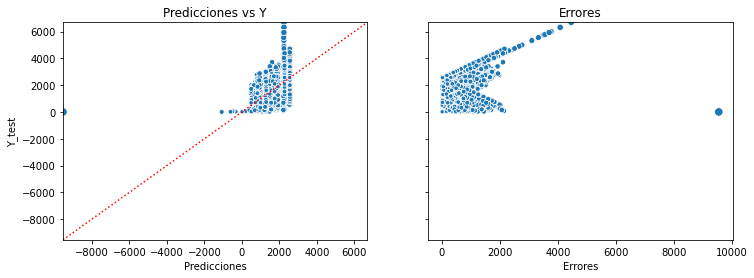

Modelo 21 - Modelo con mejor R2:


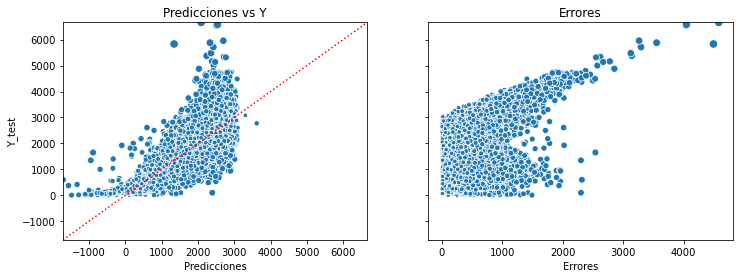

In [172]:
# Gráficamos algnos modelos y errores a modo de comparación:
X = data_filtro[feature_cols21]
y = data_filtro.price_usd_per_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
lm = LinearRegression()
modelo21 = lm.fit(X_train, y_train)
predictions21 = modelo21.predict(X)

W = data[feature_cols3]
z = data.price_usd_per_m2

W_train, W_test, z_train, z_test = train_test_split(W, z, random_state=10)
lm = LinearRegression()
modelo3 = lm.fit(W_train, z_train)
predictions3 = modelo3.predict(W)

def plot_y(modelo, X, Y):
    
    pred = modelo.predict(X)
    errores = (Y - pred).abs()
    
    if pred.max() > Y.max():
        maxi = pred.max()
    else:
        maxi = Y.max()
    if pred.min() < Y.min():
        mini = pred.min()
    else:
        mini = Y.min()
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4), sharey=True)
    sns.scatterplot(x=pred, y=Y, ax=ax1, size=(errores).tolist(), legend=False)
    ax1.set_title('Predicciones vs Y')
    ax1.set_ylim(mini,maxi),ax1.set_xlim(mini,maxi),ax1.set_xlabel('Predicciones'),ax1.set_ylabel('Y_test')
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='red',linestyle=':')
    sns.scatterplot(x=errores, y=Y, ax=ax2, size=(errores).tolist(),legend=False)
    ax2.set_title('Errores')
    ax2.set_xlabel('Errores'),ax2.set_ylabel('Y_test')
    plt.show();

# Analizamos las diferencias entre el tercer modelo y el último:
print('Modelo 3 - Variables surface_total_in_m2, centro_urbano y property_type:')
plot_y(modelo3, X=W_test, Y=z_test)
print('Modelo 21 - Modelo con mejor R2:')
plot_y(modelo21, X=X_test, Y=y_test)


Finalmente, graficamos las predicciones del primer modelo y de nuestro mejor modelo.

Un modelo perfecto se vería como una línea recta a 45 grados como la que vemos en gris.

In [166]:
#Instanciamos el modelo 1:
X = data[feature_cols1]
y = data.price_usd_per_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
lm = LinearRegression()
modelo = lm.fit(X_train, y_train)
predictions1 = modelo.predict(X)

Modelo 1 - Con variable surface_total_in_m2:
     Modelo de regresión con variable surface_total_in_m2


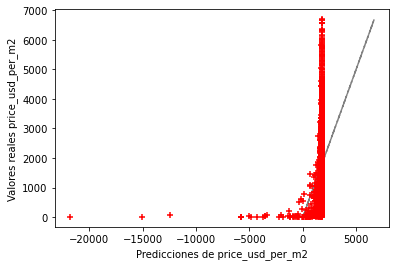

In [167]:
# Graficamos el modelo 1:
print('Modelo 1 - Con variable surface_total_in_m2:')
print('     Modelo de regresión con variable surface_total_in_m2')
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions1, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de price_usd_per_m2")
plt.ylabel("Valores reales price_usd_per_m2")
plt.show()

In [168]:
#Instanciamos el modelo 21:
X = data_filtro[feature_cols21]
y = data_filtro.price_usd_per_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
lm = LinearRegression()
modelo = lm.fit(X_train, y_train)
predictions21 = modelo.predict(X)

Modelo 21
              Modelo de regresión con mejor R2


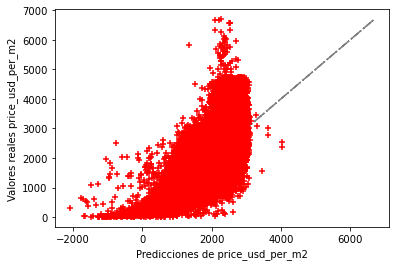

R2: 0.6022


In [169]:
# Y lo graficamos:
print('Modelo 21')
print('              Modelo de regresión con mejor R2')
plt.plot(y,y, '-.',c='gray')
plt.scatter(predictions21, y, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de price_usd_per_m2")
plt.ylabel("Valores reales price_usd_per_m2")
plt.show()

print('R2:', modelo.score(X_test, y_test).round(4))

Para concluir, analizaremos mediante statsmodel cuales son las variables que no aportan al modelo segun su p-value.

              Modelo de regresión con mejor R2


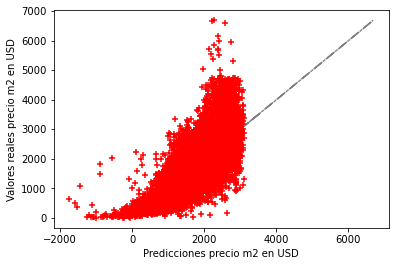

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     1156.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:40:53   Log-Likelihood:            -3.2684e+05
No. Observations:               41950   AIC:                         6.538e+05
Df Residuals:                   41896   BIC:                         6.542e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [170]:
print('              Modelo de regresión con mejor R2')
stat_modelo_21 = statsmodel_linear(data_filtro, feature_cols21)